In [1]:
from google.colab import drive
drive.mount('/content/drive')
!ls

Mounted at /content/drive
drive  sample_data


In [4]:
%cd 'drive/MyDrive/219'
!ls

/content/drive/MyDrive/219
Project1-Classification.csv


In [5]:
# Importing globaly used libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt

from joblib import Memory
from tempfile import mkdtemp
from typing import List

import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.multiclass import OneVsRestClassifier, OneVsOneClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import (LinearSVC, SVC)
from sklearn import preprocessing, metrics
from sklearn.metrics import (accuracy_score,
                             auc,
                             confusion_matrix,
                             ConfusionMatrixDisplay,
                             f1_score,
                             precision_score,
                             RocCurveDisplay,
                             recall_score,
                             roc_curve,
)
from sklearn.decomposition import NMF, TruncatedSVD
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.utils.extmath import randomized_svd

%matplotlib inline

# Set the random seed to ensure consistency
SEED = 42
np.random.seed(SEED)
random.seed(SEED)

In [6]:
# Import dataset into dataframe
df = pd.read_csv('./Project1-Classification.csv')
df_origin = pd.read_csv('./Project1-Classification.csv')
# print(df.head(3)) # Print first few rows of data to learn the data
# print(df.iloc[2086,0]) # Print a specific field

## Question 1

Q1 - Part I. How many rows (samples) and columns (features) are present in the dataset?
(3150, 8)
Q1 Part IIa - Plot 3 histograms on the total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis:


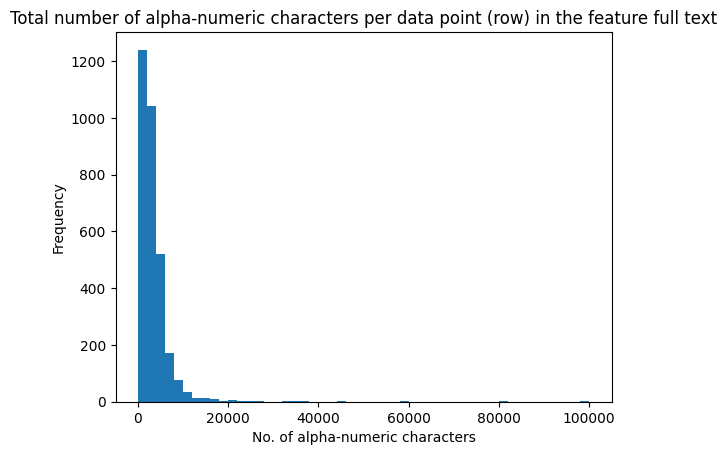

Q1 Part IIb - Plot 3 histograms on the column leaf label – class on the x-axis:


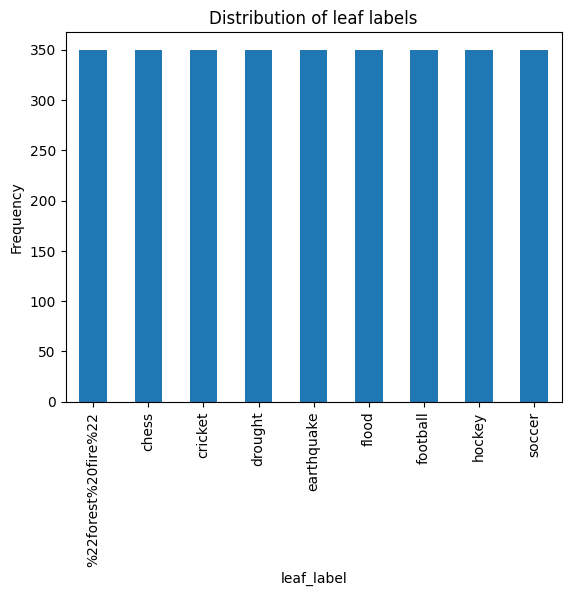

Q1 Part IIc - Plot 3 histograms on the column root label – class on the x-axis:


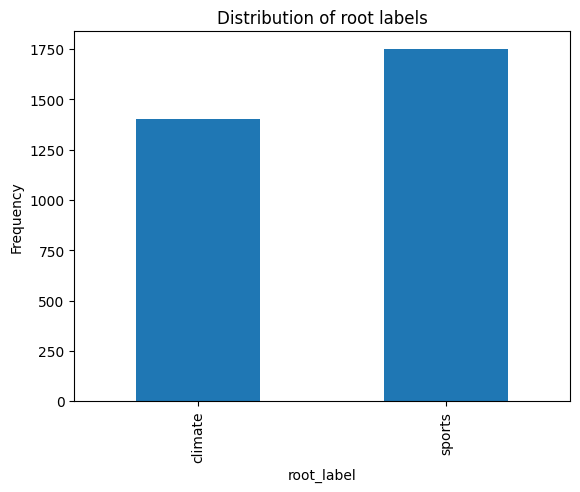

In [7]:
'''
Q1 - Part I
'''
print('Q1 - Part I. How many rows (samples) and columns (features) are present in the dataset?')
print(df.shape)


'''
Q1 - Part II
'''
alpha_numeric_char = np.array(df['full_text'].str.len()) # We did not exclude punctuation marks
# print(alpha_numeric_char)
# count = 0
# count2 = 0
# for i in range(len(alpha_numeric_char)):
#     if alpha_numeric_char[i] < 2000:
#         count += 1
#     if alpha_numeric_char[i] < 10000:
#         count2 += 1
# print('Count:', count, 'Count2:', count2)
# print('Min:', np.min(alpha_numeric_char))
# print('Max:', np.max(alpha_numeric_char))
print('Q1 Part IIa - Plot 3 histograms on the total number of alpha-numeric characters per data point (row) in the feature full text: i.e count on the x-axis and frequency on the y-axis:')
plt.title('Total number of alpha-numeric characters per data point (row) in the feature full text')
plt.xlabel('No. of alpha-numeric characters')
plt.ylabel('Frequency')
plt.hist(alpha_numeric_char, bins = 50)
plt.show()

print('Q1 Part IIb - Plot 3 histograms on the column leaf label – class on the x-axis:')
leaf_label_hist = df.groupby('leaf_label')['leaf_label'].count()
leaf_label_hist.plot.bar(rot=90, title="Distribution of leaf labels");
plt.ylabel('Frequency')
plt.show()

print('Q1 Part IIc - Plot 3 histograms on the column root label – class on the x-axis:')
leaf_label_hist = df.groupby('root_label')['root_label'].count()
leaf_label_hist.plot.bar(rot=90, title="Distribution of root labels");
plt.ylabel('Frequency')
plt.show()

### Q1 Part III - Interpret Plots: Provide qualitative interpretations of the histograms.

Alpha-numeric characters:
Less than 5% of the dataset contains more than 10000 characters, which means the dataset contains limited long text
Around 1/3 of the dataset got less than 2000 characters, which means there are a lot of short text in this dataset

Leaf labels:
The distribution of leaf labels are completely evenly distributed

Root labels:
The ratio of the climate to sports text is around 4:6

In [8]:
import re
def clean(text):
    text = re.sub(r'^https?:\/\/.*[\r\n]*', '', text, flags=re.MULTILINE)
    text = re.sub(r'http\S+', '', text, flags=re.MULTILINE)
    texter = re.sub(r'\b[0-9]+\b\s*', '', text) # Exclude purely numbers terms
    texter = re.sub(r"<br />", " ", texter)
    texter = re.sub(r"&quot;", "\"",texter)
    texter = re.sub('&#39;', "\"", texter)
    texter = re.sub('\n', " ", texter)
    texter = re.sub(' u '," you ", texter)
    texter = re.sub('`',"", texter)
    texter = re.sub(' +', ' ', texter)
    texter = re.sub(r"(!)\1+", r"!", texter)
    texter = re.sub(r"(\?)\1+", r"?", texter)
    texter = re.sub('&amp;', 'and', texter)
    texter = re.sub('\r', ' ',texter)
    clean = re.compile('<.*?>')
    texter = texter.encode('ascii', 'ignore').decode('ascii')
    texter = re.sub(clean, '', texter)
    if texter == "":
        texter = ""
    return texter

In [9]:
# Clean data
# print('Before_outer', '='*100, '\n\r', df.iloc[0,0])
df['full_text'] = df['full_text'].apply(clean)

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


True

In [10]:
def pos_clean(text):
    # Exclude terms that are numbers (e.g. “123”, “-45”, “6.7” etc.)
    text = re.sub('[+-]?([0-9]*[.])?[0-9]+', '', text)
    # Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    # Merge multiple spaces into one space
    text = re.sub(' +', ' ', text)
    return text


def stemming(text):
    stemmer = PorterStemmer()
    tokens = word_tokenize(text)
    text = " ".join([stemmer.stem(word.lower()) for word in tokens])
    return pos_clean(text)


def lemma(text):
    # https://stackoverflow.com/questions/5364493/lemmatizing-pos-tagged-words-with-nltk/51154991#51154991
    tag_map = {
        'CD':wordnet.NOUN, # cardinal number (one, two)
        'EX':wordnet.ADV, # existential ‘there’ (there)
        'IN':wordnet.ADV, # preposition/sub-conj (of, in, by)
        'JJ':wordnet.ADJ, # adjective (yellow)
        'JJR':wordnet.ADJ, # adj., comparative (bigger)
        'JJS':wordnet.ADJ, # adj., superlative (wildest)
        'NN':wordnet.NOUN, # noun, sing. or mass (llama)
        'NNS':wordnet.NOUN, # noun, plural (llamas)
        'NNP':wordnet.NOUN, # proper noun, sing. (IBM)
        'NNPS':wordnet.NOUN, # proper noun, plural (Carolinas)
        'PDT':wordnet.ADJ, # predeterminer (all, both)
        'RB':wordnet.ADV, # adverb (quickly, never)
        'RBR':wordnet.ADV, # adverb, comparative (faster)
        'RBS':wordnet.ADV, # adverb, superlative (fastest)
        'RP':wordnet.ADJ, # particle (up, off)
        'VB':wordnet.VERB, # verb base form (eat)
        'VBD':wordnet.VERB, # verb past tense (ate)
        'VBG':wordnet.VERB, # verb gerund (eating)
        'VBN':wordnet.VERB, # verb past participle (eaten)
        'VBP':wordnet.VERB, # verb non-3sg pres (eat)
        'VBZ':wordnet.VERB, # verb 3sg pres (eats)
    }
    lemmatizer = nltk.wordnet.WordNetLemmatizer()
    tokens = nltk.word_tokenize(text)
    tagged_tokens = nltk.pos_tag(tokens)
    text = " ".join([lemmatizer.lemmatize(word.lower(), pos=tag_map.get(tag, "n")) for word, tag in tagged_tokens])
    return pos_clean(text)

In [11]:
df['full_text'] = df['full_text'].apply(clean)
df["full_text_lemma"] = df["full_text"].apply(lemma)
df["full_text_stem"] = df["full_text"].apply(stemming)

## Question 2
Report the number of training and testing samples

In [12]:
# df_cleaned_backup = df
# Split dataset into training and tseting set
from sklearn.model_selection import train_test_split
train, test = train_test_split(df, test_size=0.2)
print('Q2 - Report the number of training and testing samples:')
print('Training Samples:', len(train))
print('Testing Samples:', len(test))

Q2 - Report the number of training and testing samples:
Training Samples: 2520
Testing Samples: 630


## Question 3
Use the following specs to extract features from the textual data

In [13]:
pipe = Pipeline([
    ('count', CountVectorizer(stop_words='english', min_df=3)),
    ('tfidf', TfidfTransformer())])

X_train = pipe.fit_transform(train["full_text_lemma"])
X_test = pipe.transform(test["full_text_lemma"])

In [14]:
print(f'Train set shape: {X_train.shape}\nTest set shape: {X_test.shape}')

Train set shape: (2520, 14199)
Test set shape: (630, 14199)


### What are the pros and cons of lemmatization versus stemming? How do these processes affect the dictionary size?

Lemmatization s more accurate but also consumes more computational power. It uses a dictionary-based approach and considers the context and POS to determine its lemma. On the other hand, stemming uses a rule-based approach to remove suﬀixes from a word, which is less accurate but saves power.

Regarding dictionary size, lemmatization typically results in a smaller dictionary size because words are reduced to their base forms based on context and POS. Stemming typically results in a more extensive dictionary because it only removes suﬀixes, which may not always transform the word to its base form.

### min df means minimum document frequency. How does varying min df change the TF-IDF matrix?

A higher min_df value leads to a smaller matrix that only includes words frequently appearing among tons of documents. However, this may also exclude essential words that appear in fewer documents. On the other hand, a low min_df value will lead to a larger matrix that includes a bunch of words that appear in fewer documents but may also include less informative words. As the min_df value increases, the number of words that appear in many records in the matrix increases, while the number of words that appear in fewer documents will decrease, and vice versa.

### Should I remove stopwords before or after lemmatizing? Should I remove punctuations before or after lemmatizing? Should I remove numbers before or after lemmatizing? Hint: Recall that the full sentence is input into the Lemmatizer and the lemmatizer is tagging the position of every word based on the sentence structure.

Since the whole sentence is input into the Lemmatizer, the Lemmatizer tags the position of each word based on the sentence structure. If we use stopwords before the Lemmatizer, the word structure Lemmatizer receives is broken since some words are removed already. As a result:
1. Perform lemmatizing before removing stopwords. 
2. Perform lemmatizing before removing punctuations. 
3. Perform lemmatizing before removing numbers.

### Report the shape of the TF-IDF-processed train and test matrices. The number of rows should match the results of Question 2. The number of columns should roughly be in the order of k×10^3. This dimension will vary depending on your exact method of cleaning and lemmatizing and that is okay.

As shown above, the train set shape is (2520, 14199) and the test set shape: (630, 14199).

## QUESTION 4: Reduce the dimensionality of the data using the methods above:

In [15]:
k_options = [1, 10, 50, 100, 200, 500, 1000, 2000]
explained_variance_ratio_cross_k = []
sum_explained_variance_ratio_cross_k = []

for k in k_options:
    lsi = TruncatedSVD(n_components=k, random_state=SEED)
    X_train_LSI = lsi.fit_transform(X_train)
    explained_variance_ratio_cross_k.append(lsi.explained_variance_ratio_)
    sum_explained_variance_ratio_cross_k.append(lsi.explained_variance_ratio_.sum())

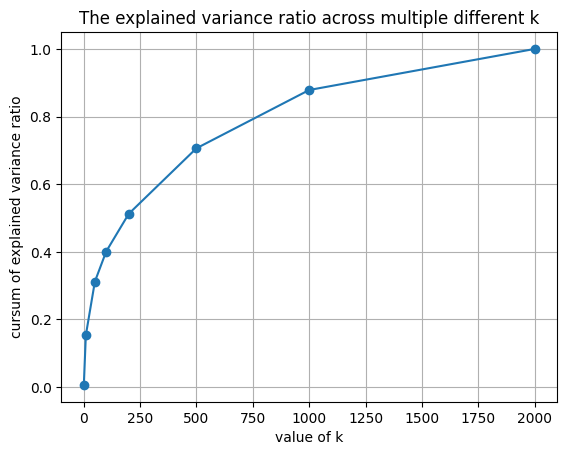

In [16]:
plt.plot(k_options, sum_explained_variance_ratio_cross_k, marker='o')
plt.xlabel("value of k")
plt.ylabel("cursum of explained variance ratio")
plt.title("The explained variance ratio across multiple different k")
plt.grid()
plt.show()

In [18]:
lsi = TruncatedSVD(n_components=50, random_state=SEED)
X_train_LSI = lsi.fit_transform(X_train)
U, sigma, V = randomized_svd(X_train, n_components=50)
print(f"LSI Error (x_train): {np.sum(np.array(X_train - U.dot(np.diag(sigma)).dot(V))**2)}")

nmf_model = NMF(n_components=50, init='random', random_state=SEED)
X_train_NMF = nmf_model.fit_transform(X_train)
H = nmf_model.components_
print(f"NMF Error (x_train): {np.sum(np.array(X_train - X_train_NMF.dot(H))**2)}")

X_test_LSI = lsi.transform(X_test)
U, sigma, V = randomized_svd(X_test, n_components=50)
print(f"LSI Error (x_test): {np.sum(np.array(X_test - U.dot(np.diag(sigma)).dot(V))**2)}")
X_test_NMF = nmf_model.transform(X_test)
H = nmf_model.components_
print(f"NMF Error (x_test): {np.sum(np.array(X_test - X_test_NMF.dot(H))**2)}")

LSI Error (x_train): 1678.2698385390513
NMF Error (x_train): 1704.091441287623
LSI Error (x_test): 400.7469450740123
NMF Error (x_test): 452.4109431322291


### Plot the explained variance ratio across multiple different k = [1, 10, 50, 100, 200, 500, 1000, 2000] for LSI and for the next few sections choose k = 50. What does the explained variance ratio plot look like? What does the plot’s concavity suggest?

As k increases, the value of f(k) decreases, i.e., the curve is concave down.

It is an array of the variance of the data explained by each of the k components. The sum of the array is 1, which means that all the components together can explain almost 99% of the data variance.
The value of variance explained increases as we add more principal components, where k=10 explains 15%, k=50 explains 31%, etc., all the way up to 99% explained by all 2000 principal components. 

### With k = 50 found in the previous sections, calculate the reconstruction residual MSE error when using LSI and NMF – they both should use the same k = 50. Which one is larger, the ||X−WH||_{F}^{2} in NMF or the ||X−U Σ V^{T}||_F^{2} in LSI and why?

LSI Error (x_train): 1678.1876624672789

NMF Error (x_train): 1704.091441287623

LSI Error (x_test): 400.79175571169276

NMF Error (x_test): 452.4109431322291

The error in NMF is larger than LSI since the added constraints of non-negativity on the matrices W and H in NMF. These constraints restrict the search space, making it more diﬀicult for the algorithm to find the optimal solution. On the other hand, LSI has a larger search space and allows for negative values in the matrices. The additional flexibility empowers the algorithm to minimize the error. 

## QUESTION 5: Compare and contrast hard-margin and soft-margin linear SVMs

In [19]:
label_encoder = preprocessing.LabelEncoder()
label_encoder.fit(train.root_label)
train['root_label_cat'] = label_encoder.transform(train.root_label)
test['root_label_cat'] = label_encoder.transform(test.root_label)

In [20]:
def evaluate(y_test, y_pred, average='binary', clf=None):
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    cm_display.plot()
    plt.show()

    fpr, tpr, thresholds = metrics.roc_curve(y_test, y_pred)
    roc_auc = metrics.auc(fpr, tpr)
    roc_display = metrics.RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc,)
    roc_display.plot()
    
    plt.show()
    
    print(f"Accuracy: {accuracy_score(y_test, y_pred)}")
    print(f"F-1 score: {f1_score(y_test, y_pred, average='binary')}")
    print(f"Recall: {recall_score(y_test, y_pred, average='binary')}")
    print(f"Precision: {precision_score(y_test, y_pred, average='binary')}")
    print('='*100, '\r\n')

/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/sklearn/svm/_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Soft margin


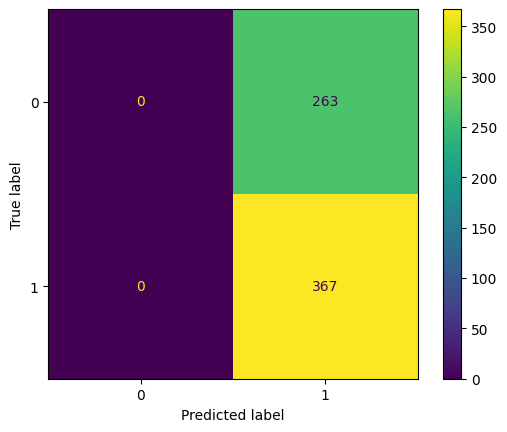

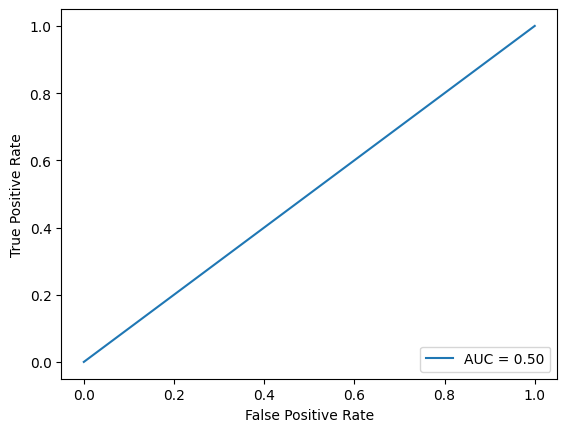

Accuracy: 0.5825396825396826
F-1 score: 0.7362086258776329
Recall: 1.0
Precision: 0.5825396825396826

Hard margin (1000)


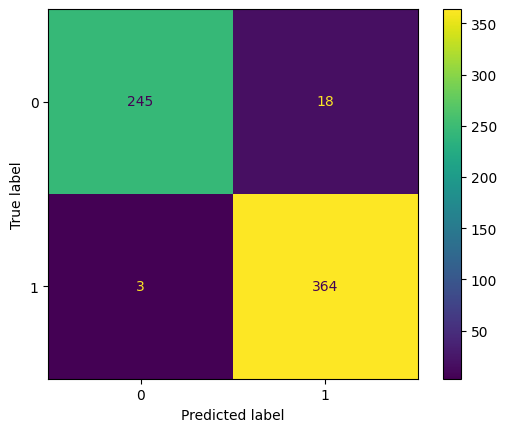

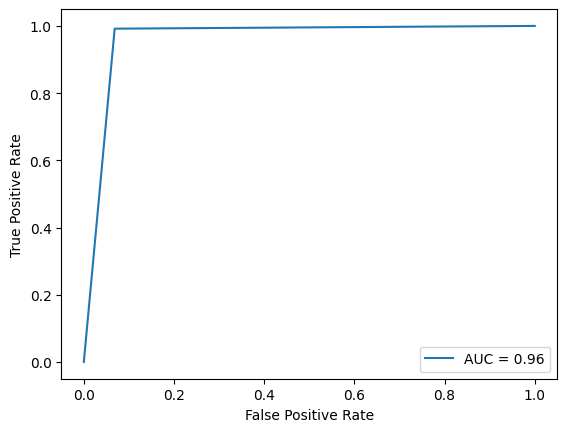

Accuracy: 0.9666666666666667
F-1 score: 0.9719626168224299
Recall: 0.9918256130790191
Precision: 0.9528795811518325

Hardest margin (100000)


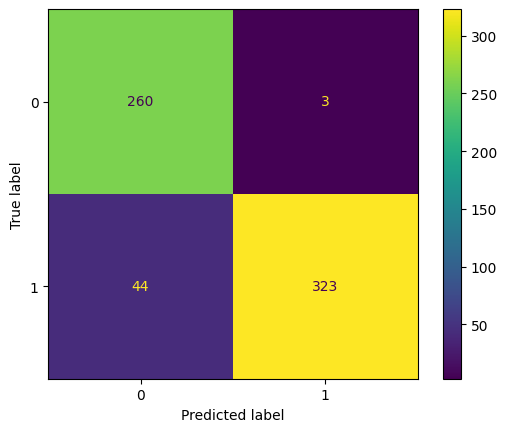

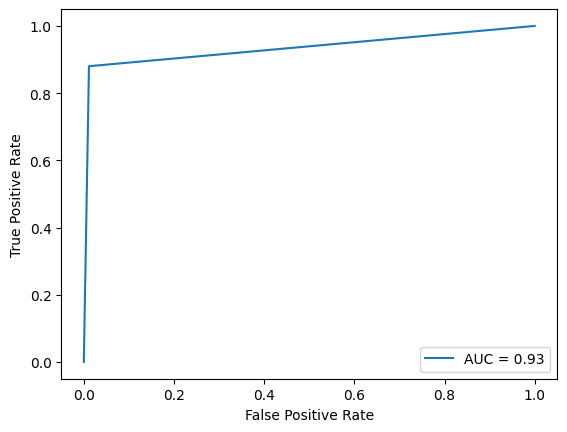

Accuracy: 0.9253968253968254
F-1 score: 0.9321789321789321
Recall: 0.8801089918256131
Precision: 0.99079754601227



In [21]:
svm_soft = LinearSVC(C=0.0001, random_state=SEED)
svm_hard = LinearSVC(C=1000, random_state=SEED)
svm_hard_100000 = LinearSVC(C=100000, random_state=SEED)
y_pred_soft = svm_soft.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
y_pred_hard = svm_hard.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
y_pred_hard_100000 = svm_hard_100000.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)

print("Soft margin")
evaluate(test['root_label_cat'], y_pred_soft, average='binary', clf=svm_soft)

print("Hard margin (1000)")
evaluate(test['root_label_cat'], y_pred_hard, average='binary', clf=svm_hard)

print("Hardest margin (100000)")
evaluate(test['root_label_cat'], y_pred_hard_100000, average='binary', clf=svm_hard_100000)

In [22]:
import warnings
warnings.filterwarnings('ignore')

svc = LinearSVC(random_state=SEED)
opts = [10**i for i in range(-3, 7)]
clf_svc = GridSearchCV(svc, {'C': opts}, cv=5, scoring='accuracy')
clf_svc.fit(X_train_LSI, train['root_label_cat'])
for c, result in zip(clf_svc.param_grid['C'], clf_svc.cv_results_['mean_test_score']):
    print(f"C={c}, average validation (accuracy): {result}")

C=0.001, average validation (accuracy): 0.6718253968253969
C=0.01, average validation (accuracy): 0.9186507936507937
C=0.1, average validation (accuracy): 0.9436507936507936
C=1, average validation (accuracy): 0.9503968253968254
C=10, average validation (accuracy): 0.9515873015873015
C=100, average validation (accuracy): 0.9503968253968254
C=1000, average validation (accuracy): 0.9428571428571428
C=10000, average validation (accuracy): 0.9198412698412699
C=100000, average validation (accuracy): 0.9472222222222223
C=1000000, average validation (accuracy): 0.9432539682539682


best margin (=10)
Best score: 0.9515873015873015


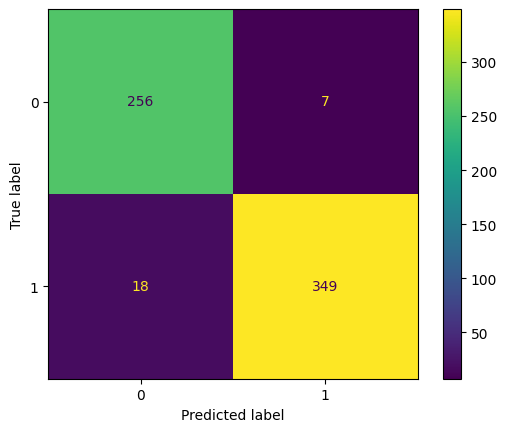

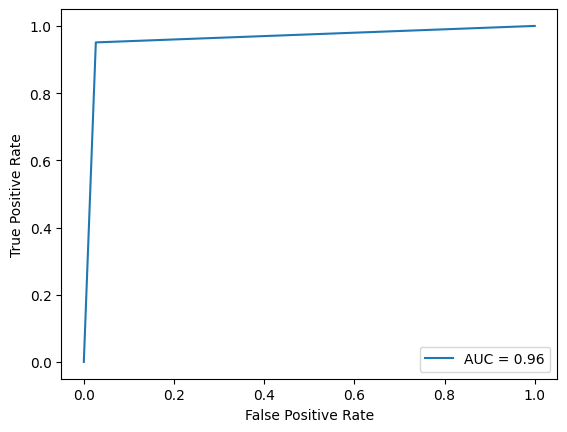

Accuracy: 0.9603174603174603
F-1 score: 0.9654218533886584
Recall: 0.9509536784741145
Precision: 0.9803370786516854



In [23]:
y_pred_best = clf_svc.best_estimator_.predict(X_test_LSI)
print(f"best margin (={clf_svc.best_estimator_.C})")
print(f'Best score: {clf_svc.best_score_}')
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_svc.best_estimator_)

### Plot the ROC curve, report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of both SVM classifiers on the testing set. Which one performs better? What about for γ = 100000?

From the above figures, it is clear that hard margin SVM (=1000) performs better than soft margin SVM (=0.0001)

Although the hardest margin SVM (=100000) has precision less than other metrics, the hardest margin SVM ( = 100000) has the best performance regarding ROC, F-1 score, accuracy, and precision.

### What happens for the soft margin SVM? Why is the case? Analyze in terms of the confusion matrix.

The objective of a soft margin support vector machine (SVM) is to accommodate some classification errors while distinguishing linearly inseparable classes. To achieve this, a wider margin is permitted, resulting in a lower emphasis on the hinge loss and less severe penalties for misclassifications. Consequently, a soft-margin SVM may exhibit higher recall but not necessarily greater precision. If the margin is too soft, all predictions may be 1, leading to a recall rate of 100% and a precision rate equal to the proportion of 1s.

### Does the ROC curve reflect the performance of the soft-margin SVM? Why?

Yes. As all predictions from a soft-margin SVM are 1, the model effectively learns nothing. Furthermore, the ROC curve of a soft-margin SVM yields an AUC of 0.5, indicating that the model's ability to accurately classify a random example is no better than random guessing. Such a model may be of limited value, as its predictive performance is comparable to that of a random classifier.

###  Use cross-validation to choose γ (use average validation 3 accuracy to compare): Using a 5-fold cross-validation, find the best value of the parameter γ in the range {10k| − 3 ≤ k ≤ 6,k ∈ Z}. Again, plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this best SVM.

C=0.001, average validation (accuracy): 0.6718253968253969

C=0.01, average validation (accuracy): 0.9186507936507937

C=0.1, average validation (accuracy): 0.9436507936507936

C=1, average validation (accuracy): 0.9503968253968254

C=10, average validation (accuracy): 0.9515873015873015

C=100, average validation (accuracy): 0.9503968253968254

C=1000, average validation (accuracy): 0.9428571428571428

C=10000, average validation (accuracy): 0.9198412698412699

C=100000, average validation (accuracy): 0.9472222222222223

C=1000000, average validation (accuracy): 0.9432539682539682

When C=10 we have the best result. Please find plots from the above cells.

## QUESTION 6: Evaluate a logistic classifier

Train a logistic classifier without regularization (you may need to come up with some way to approximate this if you use sklearn.linear model.LogisticRegression); plot the ROC curve and report the confusion matrix and calculate the accuracy, recall precision and F-1 score of this classifier on the testing set.

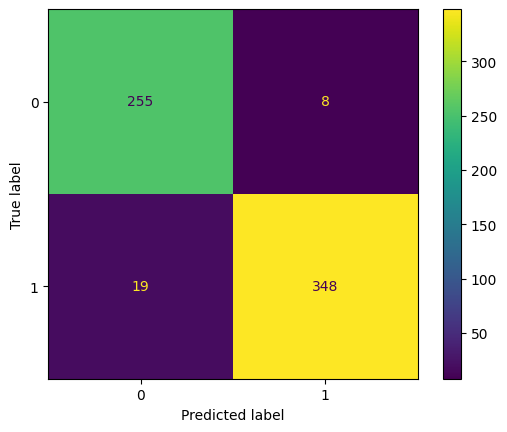

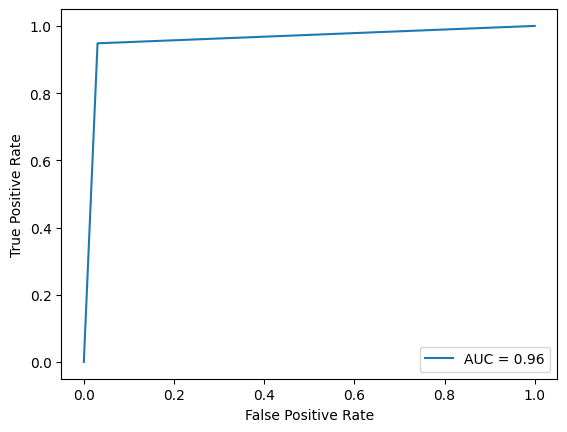

Accuracy: 0.9571428571428572
F-1 score: 0.9626556016597511
Recall: 0.9482288828337875
Precision: 0.9775280898876404



In [24]:
import math
lr = LogisticRegression(penalty=None, C=math.inf, random_state=SEED)

y_pred_lr = lr.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
evaluate(test['root_label_cat'], y_pred_lr, average='binary', clf=lr)

Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the op- timal regularization strength in the range {10k|−5 ≤ k ≤ 5,k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

In [25]:
lr = LogisticRegression(penalty=None, C=math.inf, random_state=SEED)
lr_l1 = LogisticRegression(random_state=SEED, penalty='l1', solver='liblinear')
lr_l2 = LogisticRegression(random_state=SEED, penalty='l2', solver='liblinear')

options = [10**i for i in range(-5, 6)]
params = {'C': options}

clf_lr = GridSearchCV(lr, params, cv=5, scoring='accuracy')
clf_lr.fit(X_train_LSI, train['root_label_cat'])
for c, result in zip(clf_lr.param_grid['C'], clf_lr.cv_results_['mean_test_score']):
    print(f"(W/o reg) C={c}, average validation (accuracy): {result}")


clf_lr_l1 = GridSearchCV(lr_l1, params, cv=5, scoring='accuracy')
clf_lr_l1.fit(X_train_LSI, train['root_label_cat'])
for c, result in zip(clf_lr_l1.param_grid['C'], clf_lr_l1.cv_results_['mean_test_score']):
    print(f"(L1 reg)  C={c}, average validation (accuracy): {result}")

clf_lr_l2 = GridSearchCV(lr_l2, params, cv=5, scoring='accuracy')
clf_lr_l2.fit(X_train_LSI, train['root_label_cat'])
for c, result in zip(clf_lr_l2.param_grid['C'], clf_lr_l1.cv_results_['mean_test_score']):
    print(f"(L2 reg)  C={c}, average validation (accuracy): {result}")

(W/o reg) C=1e-05, average validation (accuracy): 0.9511904761904761
(W/o reg) C=0.0001, average validation (accuracy): 0.9511904761904761
(W/o reg) C=0.001, average validation (accuracy): 0.9511904761904761
(W/o reg) C=0.01, average validation (accuracy): 0.9511904761904761
(W/o reg) C=0.1, average validation (accuracy): 0.9511904761904761
(W/o reg) C=1, average validation (accuracy): 0.9511904761904761
(W/o reg) C=10, average validation (accuracy): 0.9511904761904761
(W/o reg) C=100, average validation (accuracy): 0.9511904761904761
(W/o reg) C=1000, average validation (accuracy): 0.9511904761904761
(W/o reg) C=10000, average validation (accuracy): 0.9511904761904761
(W/o reg) C=100000, average validation (accuracy): 0.9511904761904761
(L1 reg)  C=1e-05, average validation (accuracy): 0.4511904761904762
(L1 reg)  C=0.0001, average validation (accuracy): 0.4511904761904762
(L1 reg)  C=0.001, average validation (accuracy): 0.4511904761904762
(L1 reg)  C=0.01, average validation (accura

### Using 5-fold cross-validation on the dimension-reduced-by-SVD training data, find the op- timal regularization strength in the range {10k|−5 ≤ k ≤ 5,k ∈ Z} for logistic regression with L1 regularization and logistic regression with L2 regularization, respectively.

(L1 reg) Optimal validation accuracy is 0.9527777777777777.

(L2 reg) Optimal validation accuracy is 0.9527777777777777.

### Compare the performance (accuracy, precision, recall and F-1 score) of 3 logistic classi- fiers: w/o regularization, w/ L1 regularization and w/ L2 regularization (with the best parameters you found from the part above), using test data.

w/o regularization
best margin ( = 1e-05)


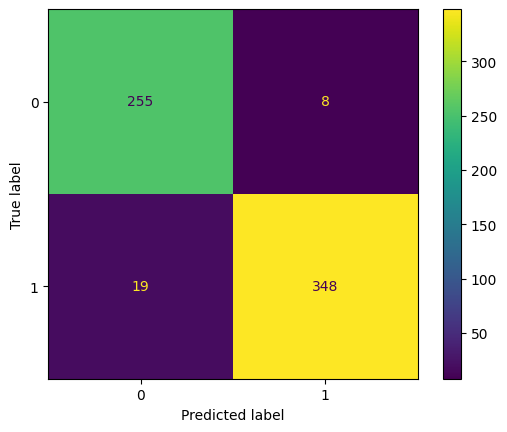

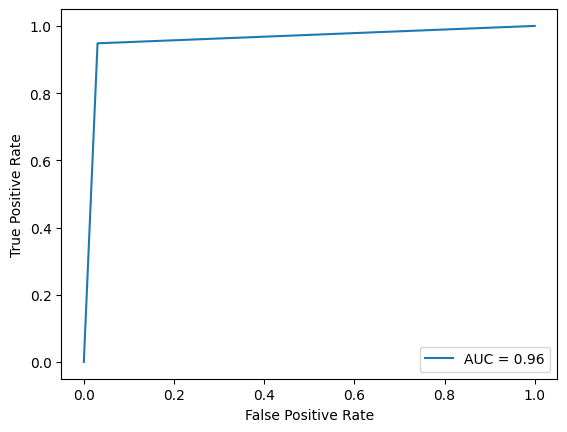

Accuracy: 0.9571428571428572
F-1 score: 0.9626556016597511
Recall: 0.9482288828337875
Precision: 0.9775280898876404

L1 regularization
best margin ( = 1000)


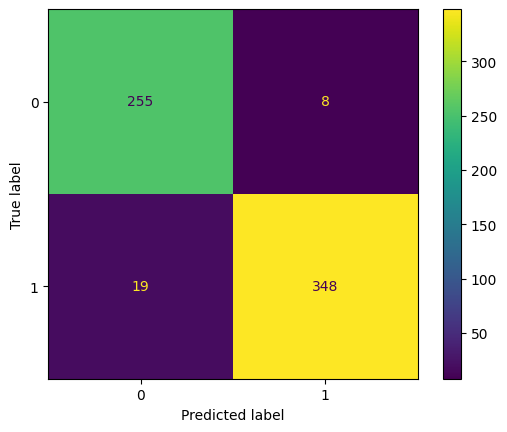

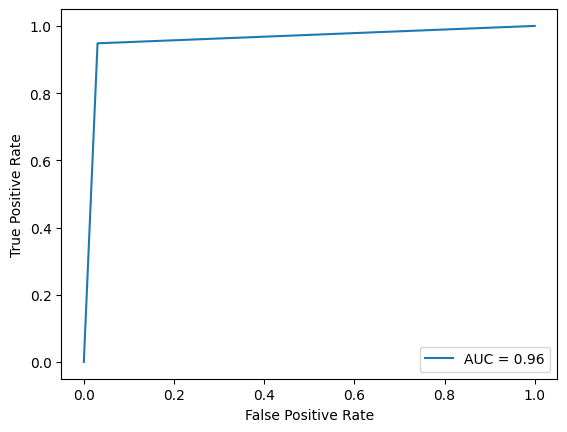

Accuracy: 0.9571428571428572
F-1 score: 0.9626556016597511
Recall: 0.9482288828337875
Precision: 0.9775280898876404

L2 regularization
best margin ( = 1000)


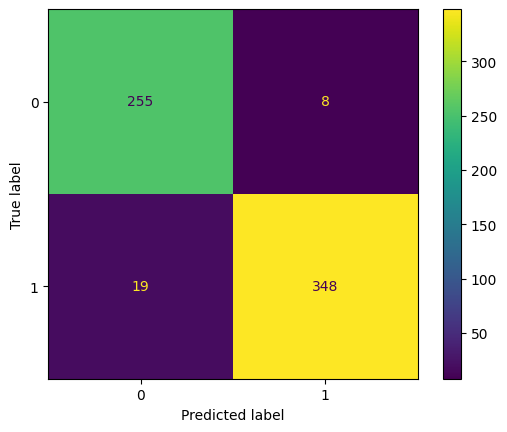

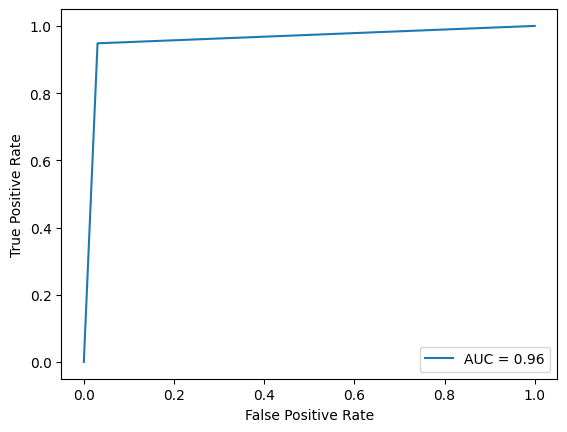

Accuracy: 0.9571428571428572
F-1 score: 0.9626556016597511
Recall: 0.9482288828337875
Precision: 0.9775280898876404



In [26]:
print("w/o regularization")
y_pred_best = clf_lr.best_estimator_.predict(X_test_LSI)
print(f"best margin ( = {clf_lr.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_lr.best_estimator_)

print("L1 regularization")
y_pred_best = clf_lr_l1.best_estimator_.predict(X_test_LSI)
print(f"best margin ( = {clf_lr_l1.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_lr_l1.best_estimator_)

print("L2 regularization")
y_pred_best = clf_lr_l2.best_estimator_.predict(X_test_LSI)
print(f"best margin ( = {clf_lr_l2.best_estimator_.C})")
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=clf_lr_l2.best_estimator_)

### How does the regularization parameter affect the test error? How are the learnt coeffi- cients affected? Why might one be interested in each type of regularization?


L2 regularization: To address the multicollinearity problem, L2 regularization can limit the magnitude of the coefficients while retaining all variables. In contrast to L1 regularization, L2 regularization is less prone to setting coefficients to zero, which can be either advantageous or disadvantageous depending on the particular use case. Typically, the learned coefficients in L2 regularization are smaller than those in logistic regression without regularization. This regularization technique is useful for preventing the model from relying too heavily on a few features, thereby decreasing its sensitivity to small fluctuations in the feature vectors and increasing its robustness.

L1 regularization: In  some cases, some of the coefficients learned from L1 regularization may be zero, and most coefficients are typically smaller than those learned from logistic regression without any regularization. This regularization technique is valuable for constructing a sparse model by eliminating features, which is known as feature selection. This approach preserves the most relevant features in the model. By constraining the coefficient norm and setting some coefficients to zero, L1 regularization can address the multicollinearity problem. However, Lasso regression, which is regression with an L1 penalty, is a quadratic program that requires specialized tools to solve. When there are more features than observations, Lasso will retain at most non-zero coefficients. This might not be ideal in certain situations. L1 regularization is sometimes utilized as a feature selection technique.

w/o regularization: When there is no regularization, the model’s coeﬀicients tend to be large, making the model unstable and prone to overfitting. However, this type of regularization can be useful if we desire to construct complicated models for handling complex data with no indications of overfitting.

### Both logistic regression and linear SVM are trying to classify data points using a linear decision boundary. What is the difference between their ways to find this boundary? Why do their performances differ? Is this difference statistically significant?

1. Logistic Regression is a classification model that predicts the likelihood of a specific event occurring. By utilizing the activation functions (such as sigmoid), it transforms input values into probabilities ranging from 0 to 1, and it aims to maximize the conditional likelihood of the training data. However, it is sensitive to outliers and necessitates standardization to prevent feature weights from dominating others. It is a probabilistic approach that strives to enhance the accuracy of classification on the entire training set by providing probability scores for each class, which leads to a decision boundary based on the input data. On the other hand, Support Vector Machine (SVM) is a classification algorithm that maximizes the margin between class variables by identifying the decision boundary that separates positive and negative samples. The objective is to achieve a broad margin for the decision boundary to balance the bias-variance tradeoff. Unlike logistic regression, SVM is less affected by outliers because it focuses on points closest to the decision boundary, and it adapts the decision boundary to new positive or negative events. It's a deterministic method that employs a subset of points closest to the decision boundary (support vectors) to discover an optimal separating hyperplane that maximizes the distance of the vectors to the margin. As a result, the decision boundary generated by SVM reduces the misclassification rate.

2. In terms of performance, Logistic Regression excels at confidently classifying data points far from the hyperplane but struggles with those near the margin. On the other hand, SVM is faster and more efficient at handling complex, high-dimensional and unstructured data using the kernel trick. Logistic Regression, on the other hand, is better suited for structured datasets. However, Logistic Regression is more prone to overfitting as it relies on observations from the entire training set, while SVM achieves better generalization by using a subset of data points closest to the decision boundary (i.e., support vectors). This explains why SVM are generally more accurate than Logistic Regression.

3. No, the difference is not statistically significant from the above experiments.

## QUESTION 7: Evaluate and profile a Na ̈ıve Bayes classifier: Train a GaussianNB classifier; plot the ROC curve and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of this classifier on the testing set.

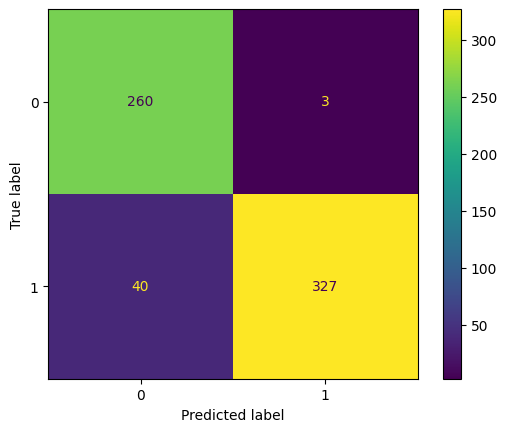

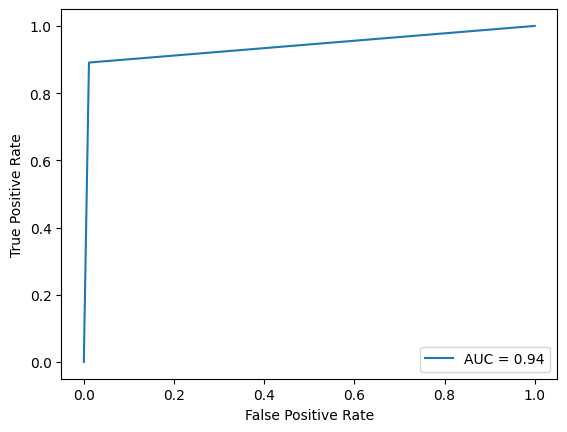

Accuracy: 0.9317460317460318
F-1 score: 0.9383070301291249
Recall: 0.8910081743869209
Precision: 0.990909090909091



In [27]:
nb = GaussianNB()
y_pred_nb = nb.fit(X_train_LSI, train['root_label_cat']).predict(X_test_LSI)
evaluate(test['root_label_cat'], y_pred_nb, average='binary', clf=nb)

## QUESTION 8: In this part, you will attempt to find the best model for binary classification

Construct a Pipeline that performs feature extraction, dimensionality reduction and classifi-
cation;
• The evaluation of each combination is performed with 5-fold cross-validation (use the average validation set accuracy across folds).
• In addition to any other hyperparameters you choose, your gridsearch must at least include: Loading Data, Feature Extraction, Dimensionality Reduction, Classifier, Other options

In [29]:
columns = ["full_text_lemma", "full_text_stem"]
methodMapping = {
    "full_text_lemma": "lemmatization",
    "full_text_stem": "stemming",
}

cachedir = mkdtemp()
memory = Memory(location=cachedir, verbose=0)

best_estimator = None
best_score = 0
best_params = None 
results = []

def append_preprocess_method(x, text_column):
    x["preprocess"] = methodMapping[text_column]
    return x

for text_column in columns:
    pipe = Pipeline([
        ('count', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', TruncatedSVD(random_state=SEED)),
        ('classify', GaussianNB()),
        ],
        memory=memory,
    )
    params = {
        'count__min_df': (3, 5),
        'dim_reduce': (
            TruncatedSVD(random_state=SEED),
            NMF(init='random', random_state=SEED)
        ),
        'dim_reduce__n_components': (5, 30, 80), # LSI, NMF
        'classify': (
            LinearSVC(C=clf_svc.best_estimator_.C, random_state=SEED), # SVM
            LogisticRegression(
                penalty='l1',
                C=clf_lr_l1.best_estimator_.C,
                random_state=SEED,
                solver='liblinear',
            ),
            LogisticRegression(
                penalty='l2',
                C=clf_lr_l2.best_estimator_.C,
                random_state=SEED,
                solver='liblinear',
            ),
            GaussianNB(),
        )
    }
    clf_grid = GridSearchCV(pipe, cv=5, n_jobs=-1, param_grid=params, scoring='accuracy') # grid search on 2*2*3*4 combinations
    clf_grid.fit(train[text_column], train['root_label_cat'])

    result = pd.DataFrame(clf_grid.cv_results_)[['params', 'mean_test_score']]
    result.params = result.params.apply(lambda x: append_preprocess_method(x, text_column))
    results.append(result)

    if clf_grid.best_score_ > best_score:
        best_score = clf_grid.best_score_
        best_estimator = clf_grid.best_estimator_
        best_params = clf_grid.best_params_
        best_params["preprocess"] = methodMapping[text_column]

Best score: 0.959920634920635
Best parameter: {'classify': LogisticRegression(C=1000, random_state=42, solver='liblinear'), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'lemmatization'}
Best estimator: Pipeline(memory=Memory(location=/tmp/tmp39l0qjjq/joblib),
         steps=[('count', CountVectorizer(min_df=5, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('dim_reduce', TruncatedSVD(n_components=80, random_state=42)),
                ('classify',
                 LogisticRegression(C=1000, random_state=42,
                                    solver='liblinear'))])


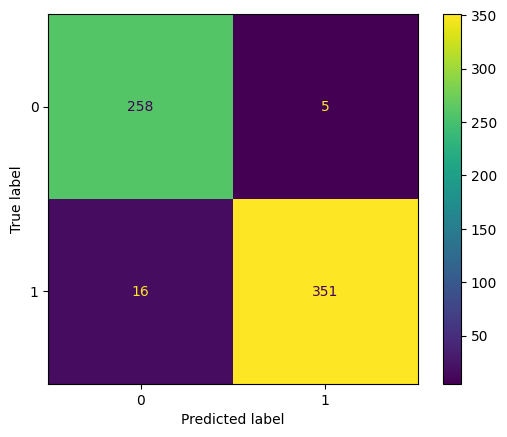

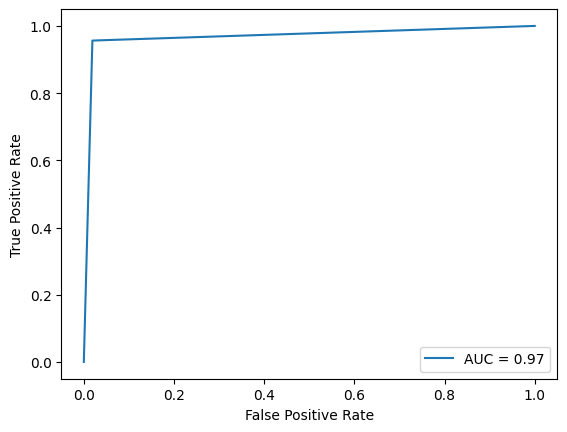

Accuracy: 0.9666666666666667
F-1 score: 0.9709543568464729
Recall: 0.9564032697547684
Precision: 0.9859550561797753



In [30]:
print(f'Best score: {best_score}')
print(f'Best parameter: {best_params}')
print(f'Best estimator: {best_estimator}')

y_pred_best = best_estimator.predict(test["full_text"])
evaluate(test['root_label_cat'], y_pred_best, average='binary', clf=best_estimator)

### What are the 5 best combinations? Report their performances on the testing set.

In [31]:
results = pd.concat(results)
results.sort_values(by='mean_test_score', ascending=False, inplace=True)
for i, (params, acc) in enumerate(results[:5][['params', 'mean_test_score']].values):
    print(f"{i+1}:\nparams={params}\nTest accuracy={acc}\n")

1:
params={'classify': LogisticRegression(C=1000, random_state=42, solver='liblinear'), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'lemmatization'}
Test accuracy=0.959920634920635

2:
params={'classify': LogisticRegression(C=1000, penalty='l1', random_state=42, solver='liblinear'), 'count__min_df': 5, 'dim_reduce': NMF(init='random', n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'stemming'}
Test accuracy=0.9591269841269842

3:
params={'classify': LogisticRegression(C=1000, random_state=42, solver='liblinear'), 'count__min_df': 3, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 'lemmatization'}
Test accuracy=0.9591269841269842

4:
params={'classify': LinearSVC(C=10, random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80, 'preprocess': 

### Question 9: In this part, we aim to learn classifiers on the documents belonging to unique classes in the column leaf label.

In [32]:
from sklearn.metrics import classification_report
def evaluate_multiple(y_test, y_pred, average='binary', clf=None):
    cm = confusion_matrix(y_test, y_pred, labels=clf.classes_)
    cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=clf.classes_)
    cm_display.plot()
    plt.show()
    
    print(classification_report(y_test, y_pred))
    print('='*100, '\r\n')

============================== Naive Bayes - Original Leaf Labels ==============================
Best score: 0.7376984126984127
Best parameter: {'classify': GaussianNB(), 'count__min_df': 5, 'dim_reduce': NMF(init='random', n_components=80, random_state=42), 'dim_reduce__n_components': 80}
Best estimator: Pipeline(memory=Memory(location=/tmp/tmp39l0qjjq/joblib),
         steps=[('count', CountVectorizer(min_df=5, stop_words='english')),
                ('tfidf', TfidfTransformer()),
                ('dim_reduce',
                 NMF(init='random', n_components=80, random_state=42)),
                ('classify', GaussianNB())])


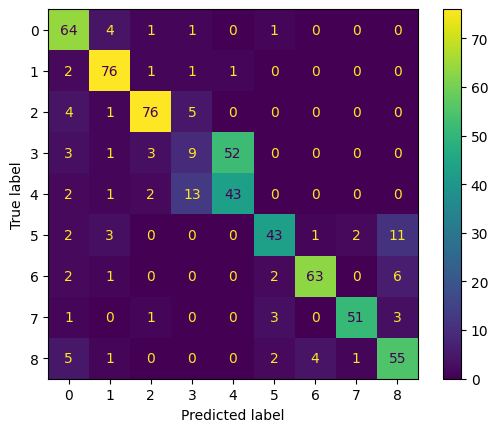

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        71
           1       0.86      0.94      0.90        81
           2       0.90      0.88      0.89        86
           3       0.31      0.13      0.19        68
           4       0.45      0.70      0.55        61
           5       0.84      0.69      0.76        62
           6       0.93      0.85      0.89        74
           7       0.94      0.86      0.90        59
           8       0.73      0.81      0.77        68

    accuracy                           0.76       630
   macro avg       0.75      0.75      0.74       630
weighted avg       0.76      0.76      0.75       630


============================== Naive Bayes - Merged Leaf Labels ==============================
Best score: 0.8480158730158731
Best parameter: {'classify': GaussianNB(), 'count__min_df': 5, 'dim_reduce': NMF(init='random', n_components=80, random_state=42), 'dim_reduce__n_components': 80}
Best 

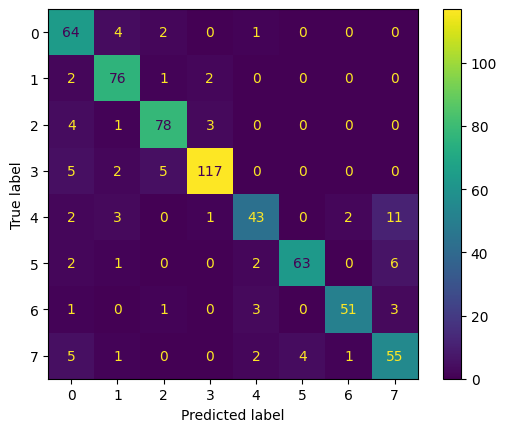

              precision    recall  f1-score   support

           0       0.75      0.90      0.82        71
           1       0.86      0.94      0.90        81
           2       0.90      0.91      0.90        86
           3       0.95      0.91      0.93       129
           4       0.84      0.69      0.76        62
           5       0.94      0.85      0.89        74
           6       0.94      0.86      0.90        59
           7       0.73      0.81      0.77        68

    accuracy                           0.87       630
   macro avg       0.87      0.86      0.86       630
weighted avg       0.87      0.87      0.87       630


============================== SVC - One vs One - Original Leaf Labels ==============================
Best score: 0.7543650793650793
Best parameter: {'classify': SVC(C=10, decision_function_shape='ovo', random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80}
Best estimato

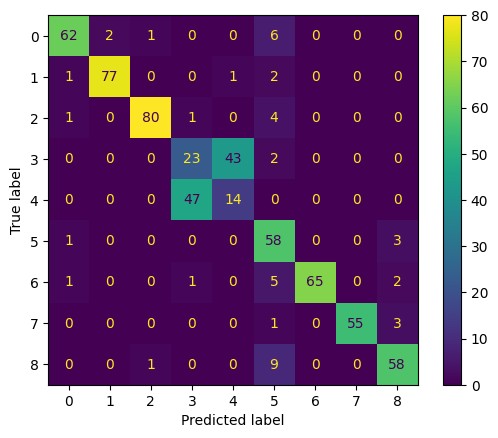

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        71
           1       0.97      0.95      0.96        81
           2       0.98      0.93      0.95        86
           3       0.32      0.34      0.33        68
           4       0.24      0.23      0.24        61
           5       0.67      0.94      0.78        62
           6       1.00      0.88      0.94        74
           7       1.00      0.93      0.96        59
           8       0.88      0.85      0.87        68

    accuracy                           0.78       630
   macro avg       0.78      0.77      0.77       630
weighted avg       0.79      0.78      0.78       630


============================== SVC - One vs One - Merged Leaf Labels ==============================
Best score: 0.9162698412698413
Best parameter: {'classify': SVC(C=10, decision_function_shape='ovo', random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_stat

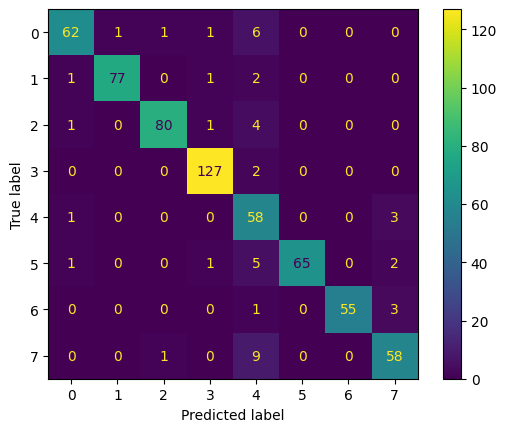

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        71
           1       0.99      0.95      0.97        81
           2       0.98      0.93      0.95        86
           3       0.97      0.98      0.98       129
           4       0.67      0.94      0.78        62
           5       1.00      0.88      0.94        74
           6       1.00      0.93      0.96        59
           7       0.88      0.85      0.87        68

    accuracy                           0.92       630
   macro avg       0.93      0.92      0.92       630
weighted avg       0.94      0.92      0.93       630


============================== SVC - One vs Rest - Original Leaf Labels ==============================
Best score: 0.7543650793650793
Best parameter: {'classify': SVC(C=10, random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80}
Best estimator: Pipeline(memory=Memory(loca

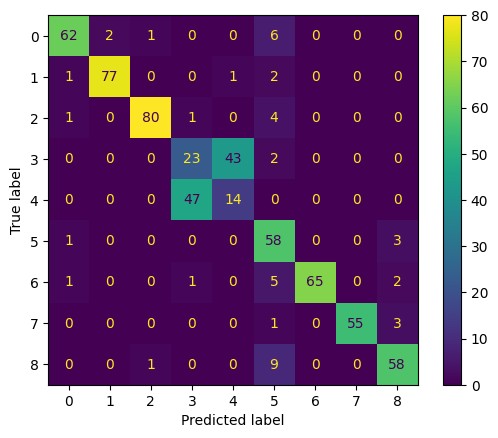

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        71
           1       0.97      0.95      0.96        81
           2       0.98      0.93      0.95        86
           3       0.32      0.34      0.33        68
           4       0.24      0.23      0.24        61
           5       0.67      0.94      0.78        62
           6       1.00      0.88      0.94        74
           7       1.00      0.93      0.96        59
           8       0.88      0.85      0.87        68

    accuracy                           0.78       630
   macro avg       0.78      0.77      0.77       630
weighted avg       0.79      0.78      0.78       630


============================== SVC - One vs Rest - Merged Leaf Labels ==============================
Best score: 0.9162698412698413
Best parameter: {'classify': SVC(C=10, random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_componen

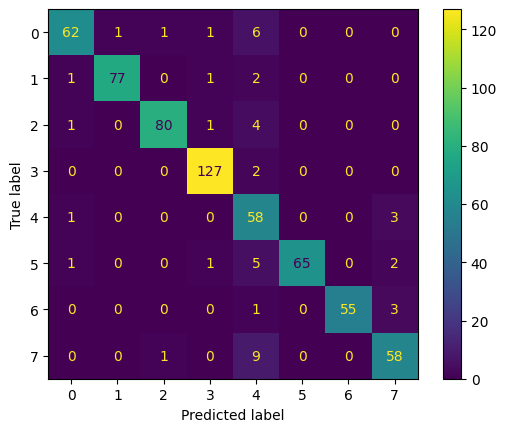

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        71
           1       0.99      0.95      0.97        81
           2       0.98      0.93      0.95        86
           3       0.97      0.98      0.98       129
           4       0.67      0.94      0.78        62
           5       1.00      0.88      0.94        74
           6       1.00      0.93      0.96        59
           7       0.88      0.85      0.87        68

    accuracy                           0.92       630
   macro avg       0.93      0.92      0.92       630
weighted avg       0.94      0.92      0.93       630


============================== SVC - One vs One (Balanced) - Original Leaf Labels ==============================
Best score: 0.7523809523809524
Best parameter: {'classify': SVC(C=10, class_weight='balanced', decision_function_shape='ovo',
    random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_

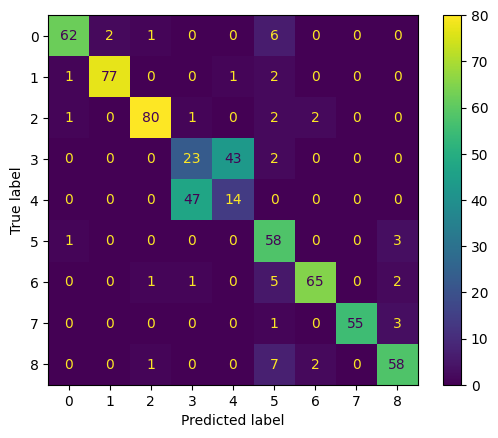

              precision    recall  f1-score   support

           0       0.95      0.87      0.91        71
           1       0.97      0.95      0.96        81
           2       0.96      0.93      0.95        86
           3       0.32      0.34      0.33        68
           4       0.24      0.23      0.24        61
           5       0.70      0.94      0.80        62
           6       0.94      0.88      0.91        74
           7       1.00      0.93      0.96        59
           8       0.88      0.85      0.87        68

    accuracy                           0.78       630
   macro avg       0.77      0.77      0.77       630
weighted avg       0.79      0.78      0.78       630


============================== SVC - One vs One (Balanced) - Merged Leaf Labels ==============================
Best score: 0.9142857142857143
Best parameter: {'classify': SVC(C=10, class_weight='balanced', decision_function_shape='ovo',
    random_state=42), 'count__min_df': 5, 'dim_reduce': T

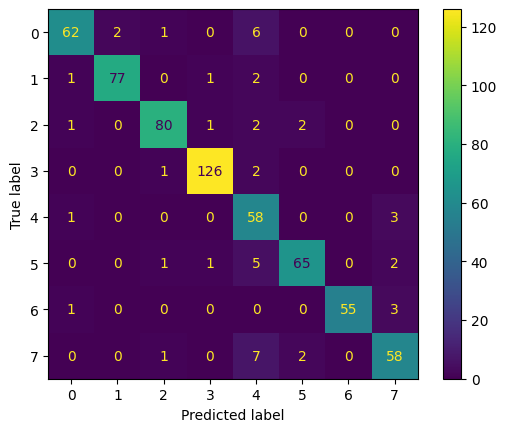

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        71
           1       0.97      0.95      0.96        81
           2       0.95      0.93      0.94        86
           3       0.98      0.98      0.98       129
           4       0.71      0.94      0.81        62
           5       0.94      0.88      0.91        74
           6       1.00      0.93      0.96        59
           7       0.88      0.85      0.87        68

    accuracy                           0.92       630
   macro avg       0.92      0.92      0.92       630
weighted avg       0.93      0.92      0.92       630


============================== SVC - One vs Rest (Balanced) - Original Leaf Labels ==============================
Best score: 0.7523809523809524
Best parameter: {'classify': SVC(C=10, class_weight='balanced', random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, random_state=42), 'dim_reduce__n_components': 80}
Best es

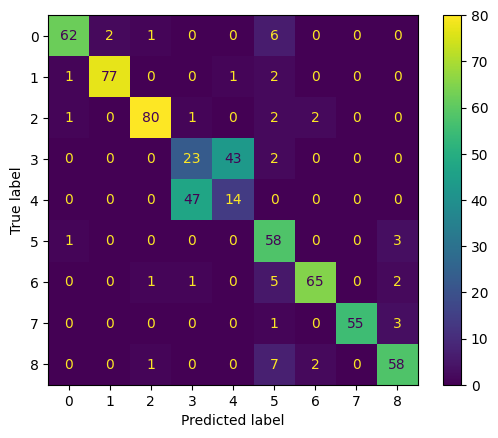

              precision    recall  f1-score   support

           0       0.95      0.87      0.91        71
           1       0.97      0.95      0.96        81
           2       0.96      0.93      0.95        86
           3       0.32      0.34      0.33        68
           4       0.24      0.23      0.24        61
           5       0.70      0.94      0.80        62
           6       0.94      0.88      0.91        74
           7       1.00      0.93      0.96        59
           8       0.88      0.85      0.87        68

    accuracy                           0.78       630
   macro avg       0.77      0.77      0.77       630
weighted avg       0.79      0.78      0.78       630


============================== SVC - One vs Rest (Balanced) - Merged Leaf Labels ==============================
Best score: 0.9142857142857143
Best parameter: {'classify': SVC(C=10, class_weight='balanced', random_state=42), 'count__min_df': 5, 'dim_reduce': TruncatedSVD(n_components=80, rando

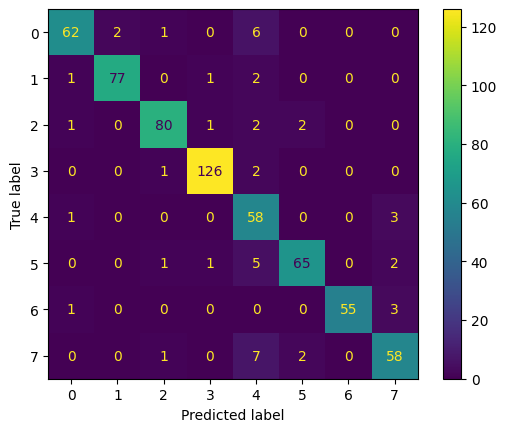

              precision    recall  f1-score   support

           0       0.94      0.87      0.91        71
           1       0.97      0.95      0.96        81
           2       0.95      0.93      0.94        86
           3       0.98      0.98      0.98       129
           4       0.71      0.94      0.81        62
           5       0.94      0.88      0.91        74
           6       1.00      0.93      0.96        59
           7       0.88      0.85      0.87        68

    accuracy                           0.92       630
   macro avg       0.92      0.92      0.92       630
weighted avg       0.93      0.92      0.92       630




In [33]:
# Map the leaf label to category number provided
map_row_to_class = {'chess':0, 'cricket':1, 'hockey':2, 'soccer':3, 'football':4, '%22forest%20fire%22':5, 'flood':6, 'earthquake':7, 'drought':8}
train['leaf_label_cat'] = train['leaf_label'].map(map_row_to_class)
test['leaf_label_cat'] = test['leaf_label'].map(map_row_to_class)
map_row_to_class_merged = {'chess':0, 'cricket':1, 'hockey':2, 'soccer':3, 'football':3, '%22forest%20fire%22':4, 'flood':5, 'earthquake':6, 'drought':7}
train['leaf_label_cat_merged'] = train['leaf_label'].map(map_row_to_class_merged)
test['leaf_label_cat_merged'] = test['leaf_label'].map(map_row_to_class_merged)

# Start training multiclass classification models
list_of_clf_multi = [
    GaussianNB(),
    SVC(C=clf_svc.best_estimator_.C, random_state=SEED, decision_function_shape='ovo'), # SVM - One vs One
    SVC(C=clf_svc.best_estimator_.C, random_state=SEED), # SVM - One vs Rest (default = ovr)
    SVC(C=clf_svc.best_estimator_.C, random_state=SEED, decision_function_shape='ovo', class_weight='balanced'), # SVM - One vs One
    SVC(C=clf_svc.best_estimator_.C, random_state=SEED, class_weight='balanced') # SVM - One vs Rest (default = ovr)
]

list_of_clf_multi = {'Naive Bayes': GaussianNB(), 
                     'SVC - One vs One': SVC(C=clf_svc.best_estimator_.C, random_state=SEED, decision_function_shape='ovo'), # SVM - One vs One
                     'SVC - One vs Rest': SVC(C=clf_svc.best_estimator_.C, random_state=SEED), # SVM - One vs Rest (default = ovr)
                     'SVC - One vs One (Balanced)': SVC(C=clf_svc.best_estimator_.C, random_state=SEED, decision_function_shape='ovo', class_weight='balanced'), # SVM - One vs One (Resolve imbalanced dataset)
                     'SVC - One vs Rest (Balanced)': SVC(C=clf_svc.best_estimator_.C, random_state=SEED, class_weight='balanced') # SVM - One vs Rest (default = ovr) (Resolve imbalanced dataset)
                    }
results_multi = []

#for text_column in columns:
for name, clf_multi in list_of_clf_multi.items():
    pipe = Pipeline([
        ('count', CountVectorizer(stop_words='english')),
        ('tfidf', TfidfTransformer()),
        ('dim_reduce', TruncatedSVD(random_state=SEED)),
        ('classify', GaussianNB()),
        ],
        memory=memory,
    )
    params = {
        'count__min_df': ([5]), # (3, 5)
        'dim_reduce': (
            TruncatedSVD(random_state=SEED),
            NMF(init='random', random_state=SEED)
        ),
        'dim_reduce__n_components': ([80]), # LSI, NMF # (5, 30, 80)
        'classify': (
            [clf_multi]
        )
    }
    clf_grid = GridSearchCV(pipe, cv=5, n_jobs=24, param_grid=params, scoring='accuracy')
    #clf_grid.fit(train[text_column], train['leaf_label_cat'])
    clf_grid.fit(train['full_text_lemma'], train['leaf_label_cat'])
    
    clf_grid_merged = GridSearchCV(pipe, cv=5, n_jobs=24, param_grid=params, scoring='accuracy')
    clf_grid_merged.fit(train['full_text_lemma'], train['leaf_label_cat_merged'])

    result = pd.DataFrame(clf_grid.cv_results_)[['params', 'mean_test_score']]
    result = pd.DataFrame(clf_grid_merged.cv_results_)[['params', 'mean_test_score']]
    #result.params = result.params.apply(lambda x: append_preprocess_method(x, text_column))
    results_multi.append(result)

    print('='*30, name, '- Original Leaf Labels', '='*30)
    #print(f'Compression Module: {text_column}')
    print(f'Best score: {clf_grid.best_score_}')
    print(f'Best parameter: {clf_grid.best_params_}')
    print(f'Best estimator: {clf_grid.best_estimator_}')

    y_pred_best = clf_grid.best_estimator_.predict(test["full_text"])
    evaluate_multiple(test['leaf_label_cat'], y_pred_best, average='binary', clf=clf_grid.best_estimator_)
    
    print('='*30, name, '- Merged Leaf Labels', '='*30)
    print(f'Best score: {clf_grid_merged.best_score_}')
    print(f'Best parameter: {clf_grid_merged.best_params_}')
    print(f'Best estimator: {clf_grid_merged.best_estimator_}')

    y_pred_best = clf_grid_merged.best_estimator_.predict(test["full_text"])
    evaluate_multiple(test['leaf_label_cat_merged'], y_pred_best, average='binary', clf=clf_grid_merged.best_estimator_)


### Perform Na¨ıve Bayes classification and multiclass SVM classification (with both One VS One and One VS the rest methods described above) and report the confusion matrix and calculate the accuracy, recall, precision and F-1 score of your classifiers. How did you resolve the class imbalance issue in the One VS the rest model?

Model training result can be found in above cell.
We can use the penalized algorithms to resolve the imbalance issue in One VS the rest model by adjusting the weight inversely proportional to class frequencies.

### Do you observe any structure in the confusion matrix? Are there distinct visible blocks on the major diagonal? What does this mean?

Lemmatization is multiclass classification is still doing better them steming in this case.
Meanwhile, most of the result falls into the diagonal of the matrix, which means the result are generally correct.
Specifically, label 3 ("soccer") & 4 ("football") are easily mixed up by the trained models, which means the categories are confusing and it's align with human sense as well

### Based on your observation from the previous part, suggest a subset of labels that should be merged into a new larger label and recompute the accuracy and plot the confusion matrix. How did the accuracy change in One VS One and One VS the rest?

Merge label 3 ("soccer") & 4 ("football").

The accuracy of the 2 SVC models both increased from 77% to 91%

### Does class imbalance impact the performance of the classification once some classes are merged? Provide a resolution for the class imbalance and recompute the accuracy and plot the confusion matrix in One VS One and One VS the rest?

The class imbalance doesn't impact the performance based on above training result

# Question 10

(a) GLoVE embeddings are trained on the ratio of co-occurence probabilities with a probe word, with respect to a word pair, because this ratio has more contextual information than the raw co-occurance probabilities for either of the words in a word pair. For example, given a word pair of "ice" and "steam", a probe word of "solid" would produce a high ratio (being related to ice but not steam), a probe word of "gas" would produce a low ratio (being related steam but not ice), and a probe word of "water" or "fashion" would produce a ratio of approximately one (as the probe word is either equally related or unrelated to both words).

(b) No, different vectors should be returned for each instance. This is due to GLoVE being dependant on both the local and global statistics of a corpus.

(c) Let us first consider the analogy, "King is to Queen as Husband is to Wife". We can encode this in vector space as King-Queen=Husband-Wife. Given that GLoVE is designed with capturing this contextual information in mind, we know that ||GLoVE["queen"] - GLoVE["king"] - GLoVE["wife"] + GLoVE["husband"]||_2 should equal approximately zero. Likewise, the value of ||GLoVE["queen"]-GLoVE["king"]||_2 and ||GLoVE["wife"]-GLoVE["husband"]||_2 are unknown individually, given that it depends on GLoVE embedding, but it can be seen that they should be relatively equal.

(d) As GLoVE not only depends on local statistics, but also global statistics, Lemmatization should be used, as it's more likely to return a valid word that can be mapped to a GLoVE embedding. That is, for example, if "saw" was stemmed to "s", it is unlikely to be mapped properly. "Saw" being lemmatized to "see", however, is more likely to map correctly.

In [ ]:
# Delete the temporary cache before exiting
#memory.clear(warn=False)
#rmtree(location)